# Доверительные интервалы

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, uniform
from functools import reduce
import numpy as np
import matplotlib
matplotlib.rc('font', size=22)
matplotlib.rc('animation', html='html5')
bigfontsize=20
labelfontsize=16
tickfontsize=16
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })




Доверительным интервалом с уровнем доверия $100\times(1-\alpha)\%$ параметра $\theta$ называется интервал значений параметра $(l,u)$ который содержит $100\times(1-\alpha)\%$ распределения апостериорной плотности вероятности:

$$ C_{\alpha}(\mathcal{D}) = (l,u): P(l\leq\theta\leq u|\mathcal{D}) = 1 - \alpha $$

Другими словами, "истинное значение" параметра $\theta$ находится в этом интервале с вероятностью $100\times(1-\alpha)\%$ (понимая всю условность термина "истинное значение параметра" в контексте байесовкой статистики.

Рассмотрим несколько примеров.

In [90]:
def discretize(pdf, plot_range, nsteps):
    dx = (plot_range[1]-plot_range[0])/nsteps
    x = np.linspace(*plot_range, nsteps)
    if type(pdf)!=dict:
        pdf_v = pdf.pdf(x)
    else:
        pdf_v = np.sum([v*k.pdf(x) for k, v in pdf.items()], axis = 0)
    return pdf_v, x, dx


    
def plot_interval(pdf, cl, interval_type, plot_range = [-5, 5], nsteps = 100):
    """
    pdf - pdf of a parameter
    cl - credibility level (0-100)
    interval_type - could be "central", "HDI","UL","LL"
    plot_range - interval for the plot
    nsteps - number grid step for numeric integration of the PDF
    """
    
    pdf_v, x, dx = discretize(pdf, plot_range, nsteps)
    
    if interval_type == "LL":
        # Upper limit is max of support
        u = plot_range[-1]
        # Finding lowe limit
        l = x[0]
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[-1-i]*dx
            if integral >=cl/100:
                l = x[-i]
                break
        mask  = x >= l
        
    if interval_type == "UL":
        l = x[0]
        u = x[-1]
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx
            if integral >=cl/100:
                u = x[i-1]
                break
        mask = x<=u

    if interval_type == "central":
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx
            if integral >=(1-cl/100)/2:
                l = x[i-1]
                break
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx                
            if integral >= 1-(1-cl/100)/2:
                u = x[i-1]  
                break
        mask = ((x>=l)&(x<=u))
    
    if interval_type == "HDI":
        sorted_pdf = np.sort(pdf_v)[::-1]
        integral = 0
        y_vals = []
        i_max = 0
        for i in range(nsteps):
            integral += sorted_pdf[i]*dx
            if integral >= cl/100:
                i_max = i-1
                break
        mask = np.in1d(pdf_v, sorted_pdf[:i_max])
        
    f = plt.figure(figsize = (10,10))
    plt.plot(x, pdf_v, color = "black")
    plt.fill_between(x, 0, pdf_v, where = mask, color = "gray", alpha = 0.2, label = str(cl)+"% CL")
    plt.legend()
    return f
    
    

## Верхний предел

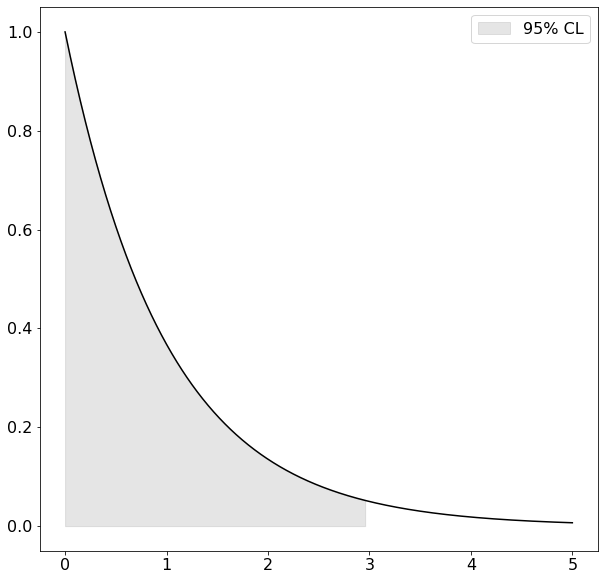

In [94]:
from scipy.stats import expon
f = plot_interval(expon, 95, "UL", plot_range = [0, 5], nsteps = 1000)

## Нижний предел

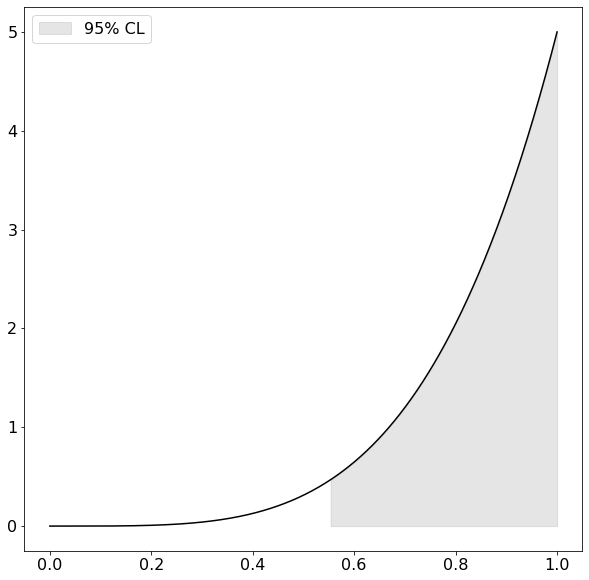

In [98]:
from scipy.stats import beta
f = plot_interval(beta(5,1), 95, "LL", plot_range = [0, 1], nsteps = 1000)

## Центральный интервал

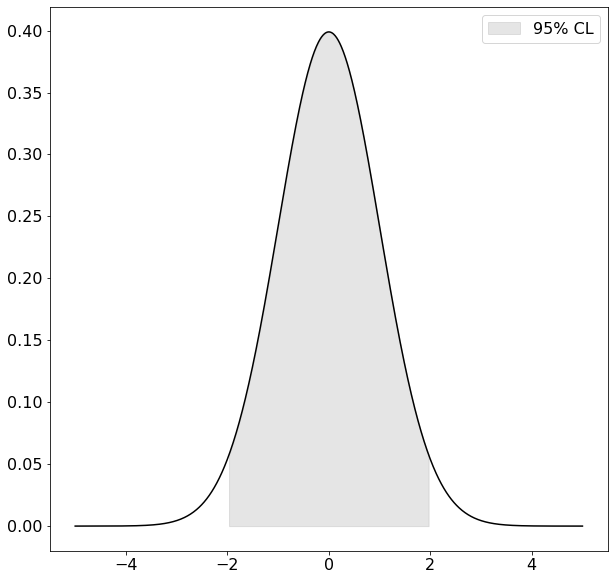

In [100]:
from scipy.stats import norm
f = plot_interval(norm(0,1), 95, "central", plot_range = [-5, 5], nsteps = 1000)

## Наименьший интервал

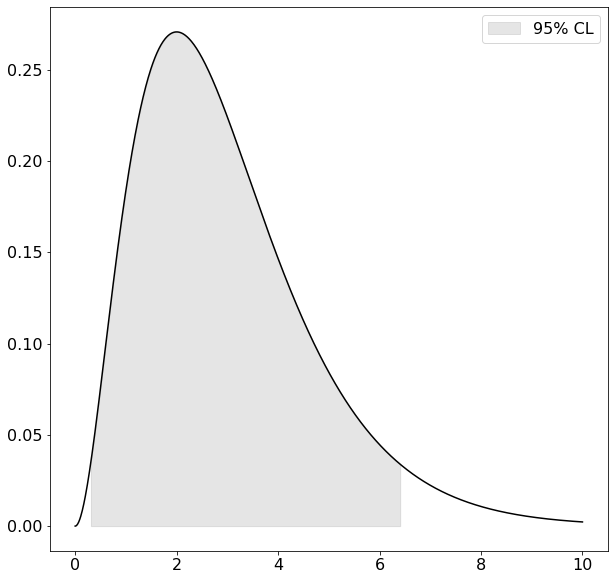

In [105]:
from scipy.stats import gamma
f = plot_interval(gamma(3), 95, "HDI", plot_range = [0, 10], nsteps = 1000)

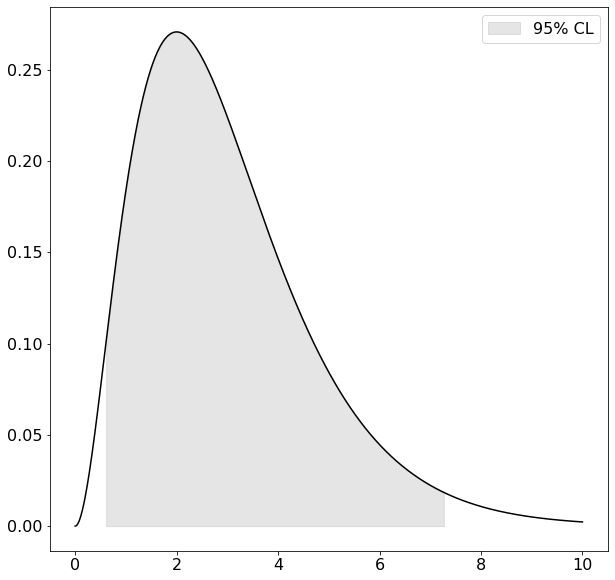

In [106]:
from scipy.stats import gamma
f = plot_interval(gamma(3), 95, "central", plot_range = [0, 10], nsteps = 1000)

## Разделенные интервалы

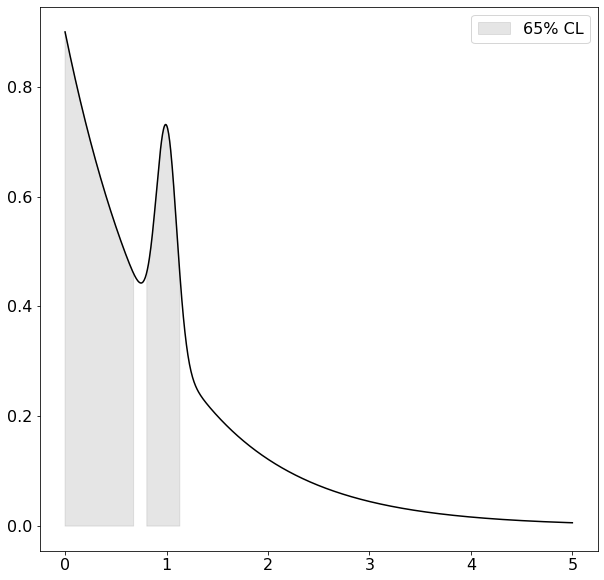

In [107]:
from scipy.stats import norm
f = plot_interval({expon:0.9, norm(1,0.1):0.1}, 65, "HDI", plot_range = [0, 5], nsteps = 1000)